# TRGAN


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline



from TRGAN.TRGAN import TRGAN, TRGANConfig, TRGANDataset
from TRGAN.dataset.catalog import get_dataset
import warnings
from TRGAN.time_generation import synthetic_deltas
from TRGAN.comparison import compare_amount
from TRGAN.comparison import compare_categorical
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

/home/llorenti/venvs/general/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/llorenti/venvs/general/lib64/python3.9/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


### Import data

In [3]:

data, metadata = get_dataset("uk_bank")

data_wrapped = TRGANDataset(
    data, 
    metadata,
    n_splits=4
)

100%|██████████| 5000/5000 [01:56<00:00, 43.03it/s]


# Time deltas comparison

Text(0.5, 1.0, 'Distribution of time between two transactions')

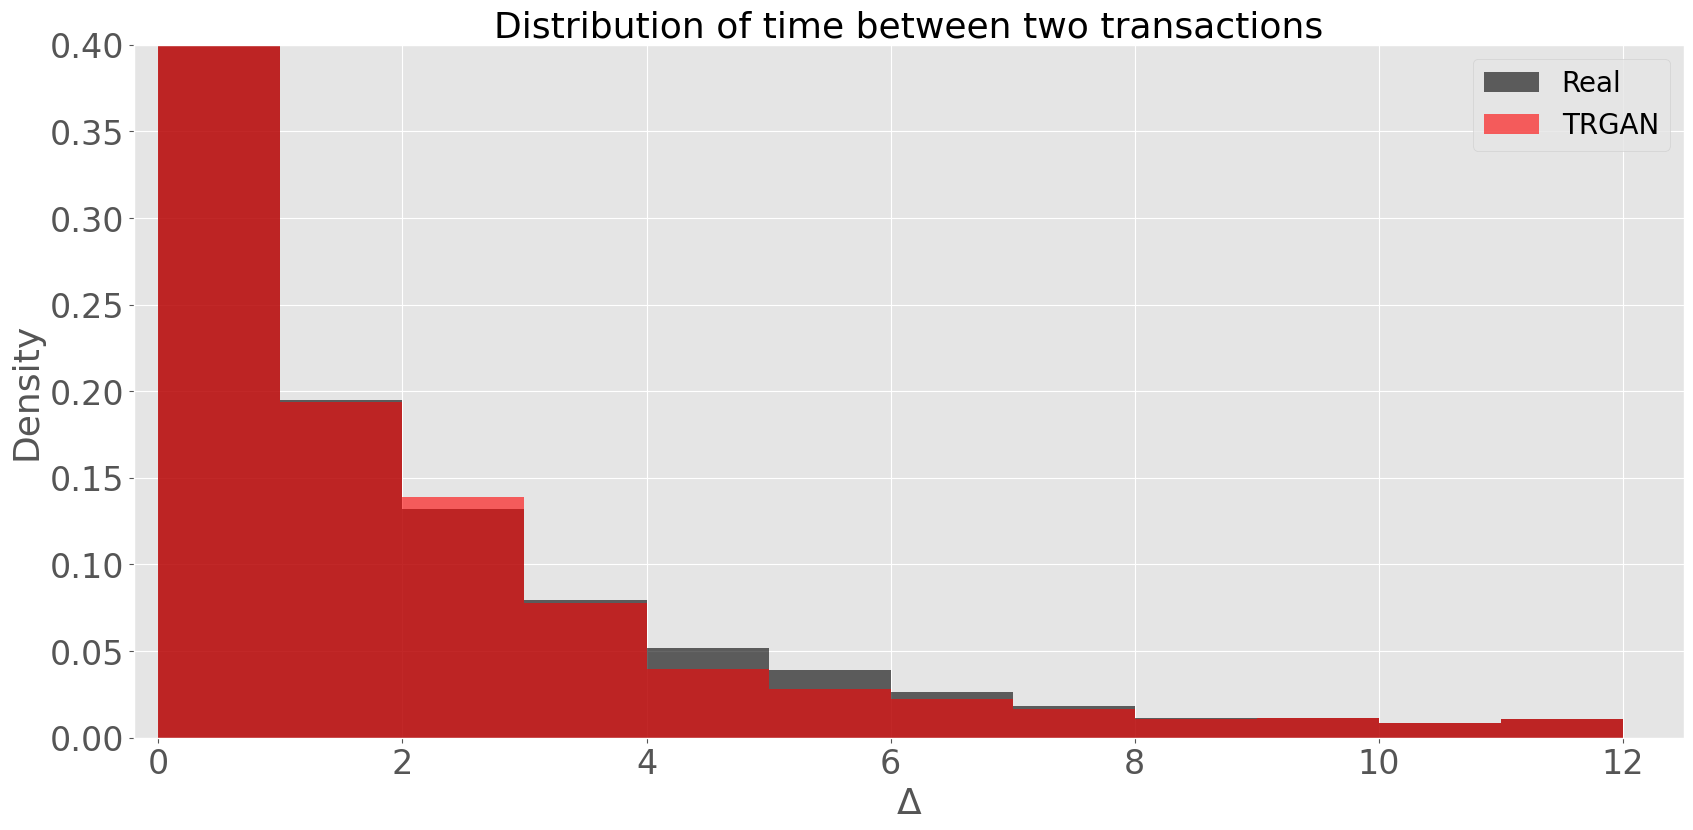

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(20, 9), dpi=100)
axs.hist(
    np.concatenate(data_wrapped.deltas.values),
    alpha=0.6,
    bins=np.arange(-1, 12) + 1,
    label="Real",
    density=True,
    color="black",
)
axs.hist(
    synthetic_deltas(data_wrapped),
    alpha=0.6,
    bins=np.arange(-1, 12) + 1,
    label="TRGAN",
    density=True,
    color="red",
)

axs.legend(fontsize=20)
axs.set_xlabel("$\Delta$", fontsize=26)
axs.set_ylabel("Density", fontsize=26)
axs.tick_params(labelsize=24)
axs.locator_params(axis="x", integer=True)
axs.set_ylim((0, 0.4))
axs.set_xlim((-0.2, 12.5))
axs.set_title("Distribution of time between two transactions", fontsize=26)


In [5]:

from TRGAN.feature_extractor import default_feature_extractor_config


model = TRGAN(
    metadata=metadata,
    config= TRGANConfig(
        num_epochs=30,
        feature_extraction =  default_feature_extractor_config(20)
    ),
    device="cpu"
)
model.train_extractor(data_wrapped)


  0%|          | 0/20 [00:00<?, ?it/s]

E_oh with (AutoEncoderConfig(dimension=30, learning_rate=5e-05, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=300.0, differential_privacy=True), 0.1)-Differential Privacy


  0%|          | 0/20 [00:00<?, ?it/s]

E_oh with (AutoEncoderConfig(dimension=12, learning_rate=0.0008, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=4, differential_privacy=True), 0.1)-Differential Privacy


  0%|          | 0/20 [00:00<?, ?it/s]

E_oh with (AutoEncoderConfig(dimension=4, learning_rate=0.001, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=4, differential_privacy=True), 0.1)-Differential Privacy


  0%|          | 0/20 [00:00<?, ?it/s]

E_oh with (AutoEncoderConfig(dimension=10, learning_rate=0.001, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=4, differential_privacy=True), 0.1)-Differential Privacy


Loss Condition vector embedder: 0.000038253 : 100%|██████████| 20/20 [00:42<00:00,  2.11s/it]


# validating the autoencoder

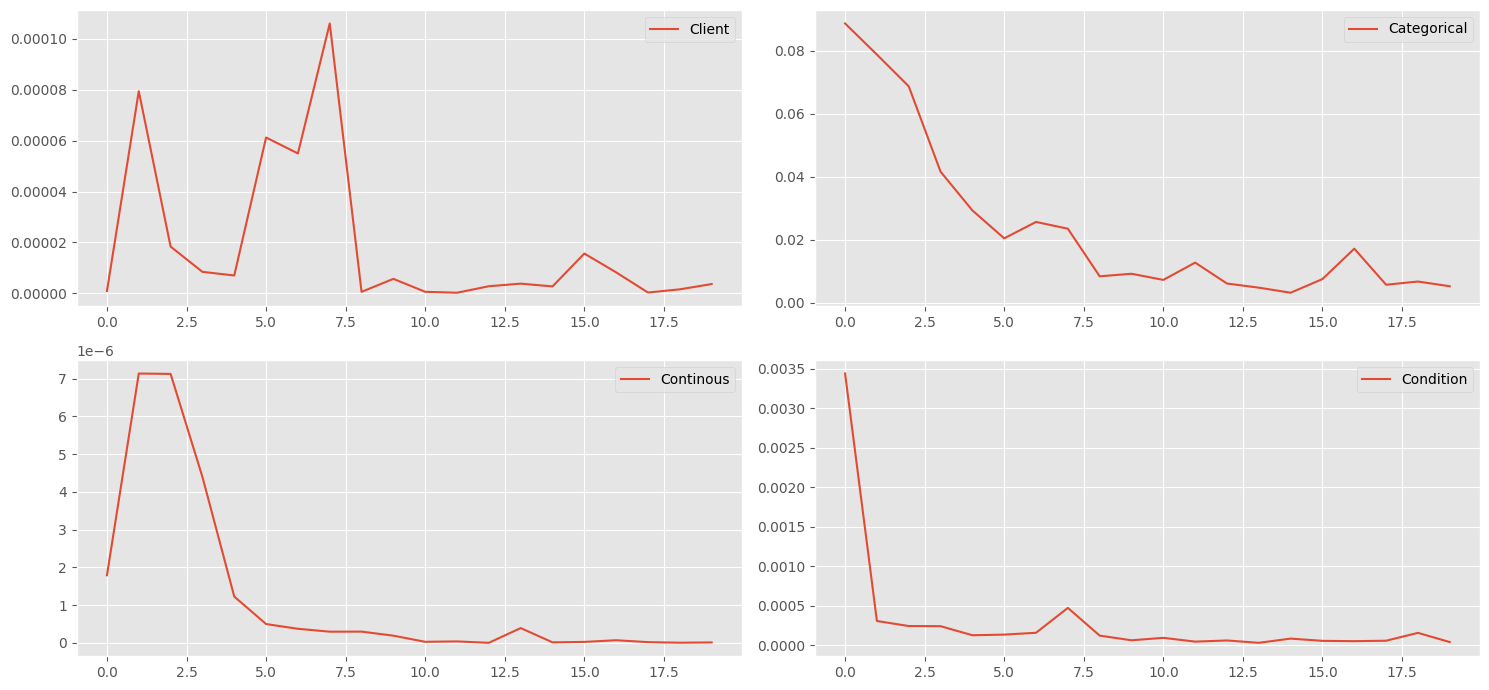

In [6]:
fig, ax = plt.subplots(2,2, figsize=(15, 7))
ax[0,0].plot(model.feature_extractor.client_embedder.history, label="Client")
ax[0,1].plot(model.feature_extractor.categorical_embedder.history,label="Categorical")
ax[1,0].plot(model.feature_extractor.continous_embedder.history, label="Continous")
ax[1,1].plot(model.feature_extractor.condition_vector_embedded.history, label="Condition")
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
fig.tight_layout()

<Axes: title={'center': 'Numerical distribution of the amount'}, xlabel='Amount', ylabel='Density'>

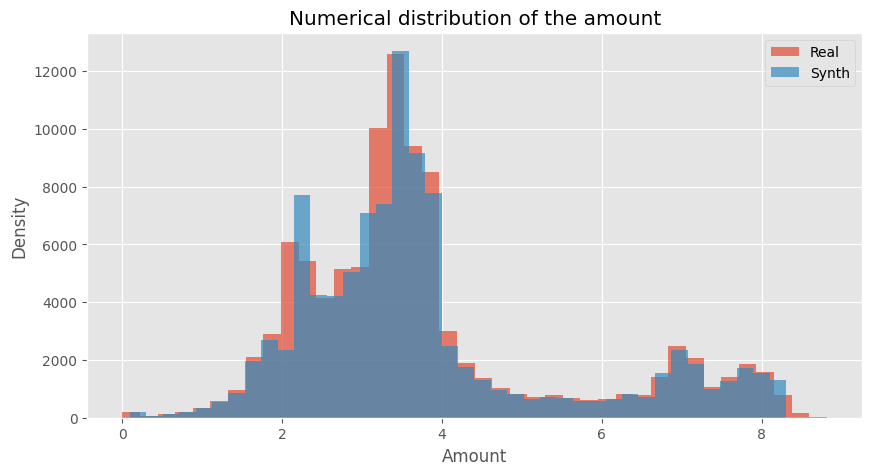

In [7]:
continous_embedder = model.feature_extractor.continous_embedder
rr = continous_embedder.inverse_transform(
    continous_embedder.encode(
        data[["amount"]]
    )
)

compare_amount(data.amount, rr.amount)


0.96844

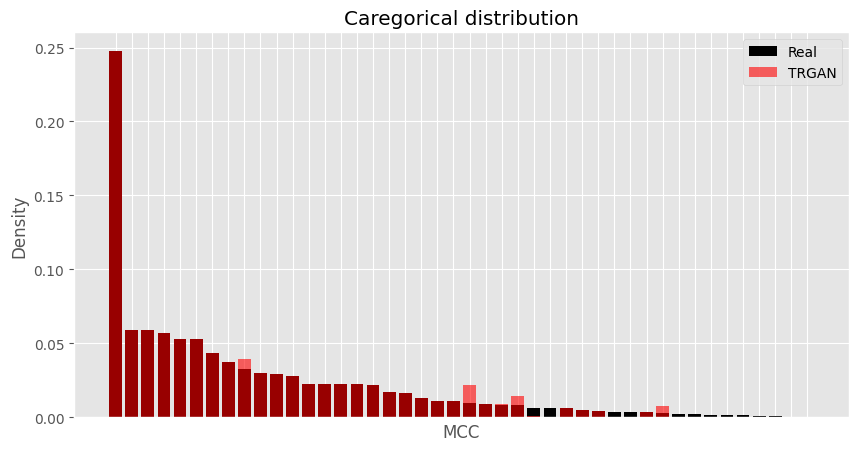

In [8]:
categorical_embedder = model.feature_extractor.categorical_embedder
qq = categorical_embedder.inverse_transform(
    categorical_embedder.encode(
        data[["mcc"]]
    )
)

compare_categorical(data.mcc, qq.mcc)
df_cat = pd.concat([data.mcc, qq.mcc], axis=1)
df_cat.columns = ["real", "synthetic"]
(df_cat["real"].astype("str") == df_cat["synthetic"].astype("str")).mean()

In [9]:
model.build_GAN()
model.train_GAN(data_wrapped)

Discriminator Loss: -0.00000 || Discriminator 2 Loss: -0.00000 || Generator Loss: 0.00077 || Supervisor Loss: 0.00006: 100%|██████████| 30/30 [20:28<00:00, 40.94s/it] 


In [10]:
import pickle
with open("model.pkl", "wb") as file:
    pickle.dump(model, file)

In [4]:
import pickle
with open("model.pkl", "rb") as file:
    model = pickle.load(file)

model.train_GAN(data_wrapped)

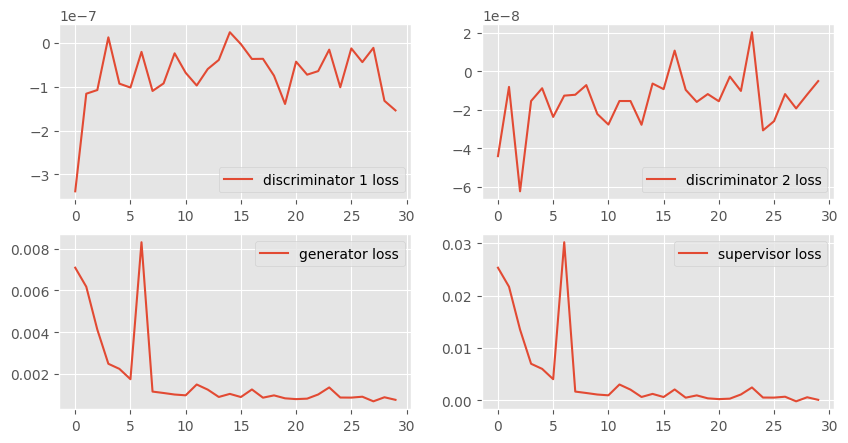

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

axs[0, 0].plot(np.array(model.loss_array).T[0], label='discriminator 1 loss')
axs[0, 1].plot(np.array(model.loss_array).T[1], label='discriminator 2 loss')
axs[1, 0].plot(np.array(model.loss_array).T[2], label='generator loss')
axs[1, 1].plot(np.array(model.loss_array).T[3], label='supervisor loss')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
plt.show()

In [5]:
rr = model.sample(data_wrapped, 100000).rename(columns={'date': 'transaction_date'})

<Axes: title={'center': 'Numerical distribution of the amount'}, xlabel='Amount', ylabel='Density'>

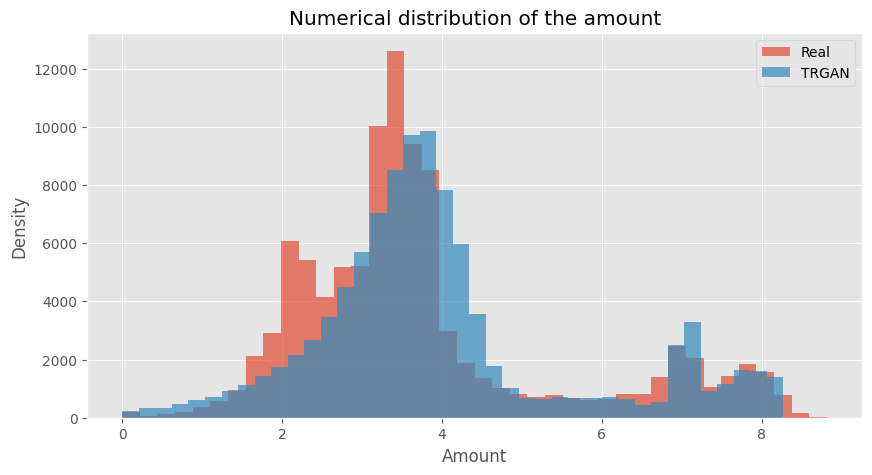

In [6]:
compare_amount(data.amount, rr.amount)


## Quality Assessment

In [16]:
synth_data, synth_time = model.sample_embedding(data_wrapped, 100000)
X_emb = model.feature_extractor.embed(data)

In [17]:
X_gr = []
X_gr.append(X_emb[:, :21].T[:7])
X_gr.append(X_emb[:, :21].T[7:14])
X_gr.append(X_emb[:, :21].T[14:21])
X_gr = np.array(X_gr)

X_gr_s = []
X_gr_s.append(synth_data[:, :21].T[:7])
X_gr_s.append(synth_data[:, :21].T[7:14])
X_gr_s.append(synth_data[:, :21].T[14:21])
X_gr_s = np.array(X_gr_s)

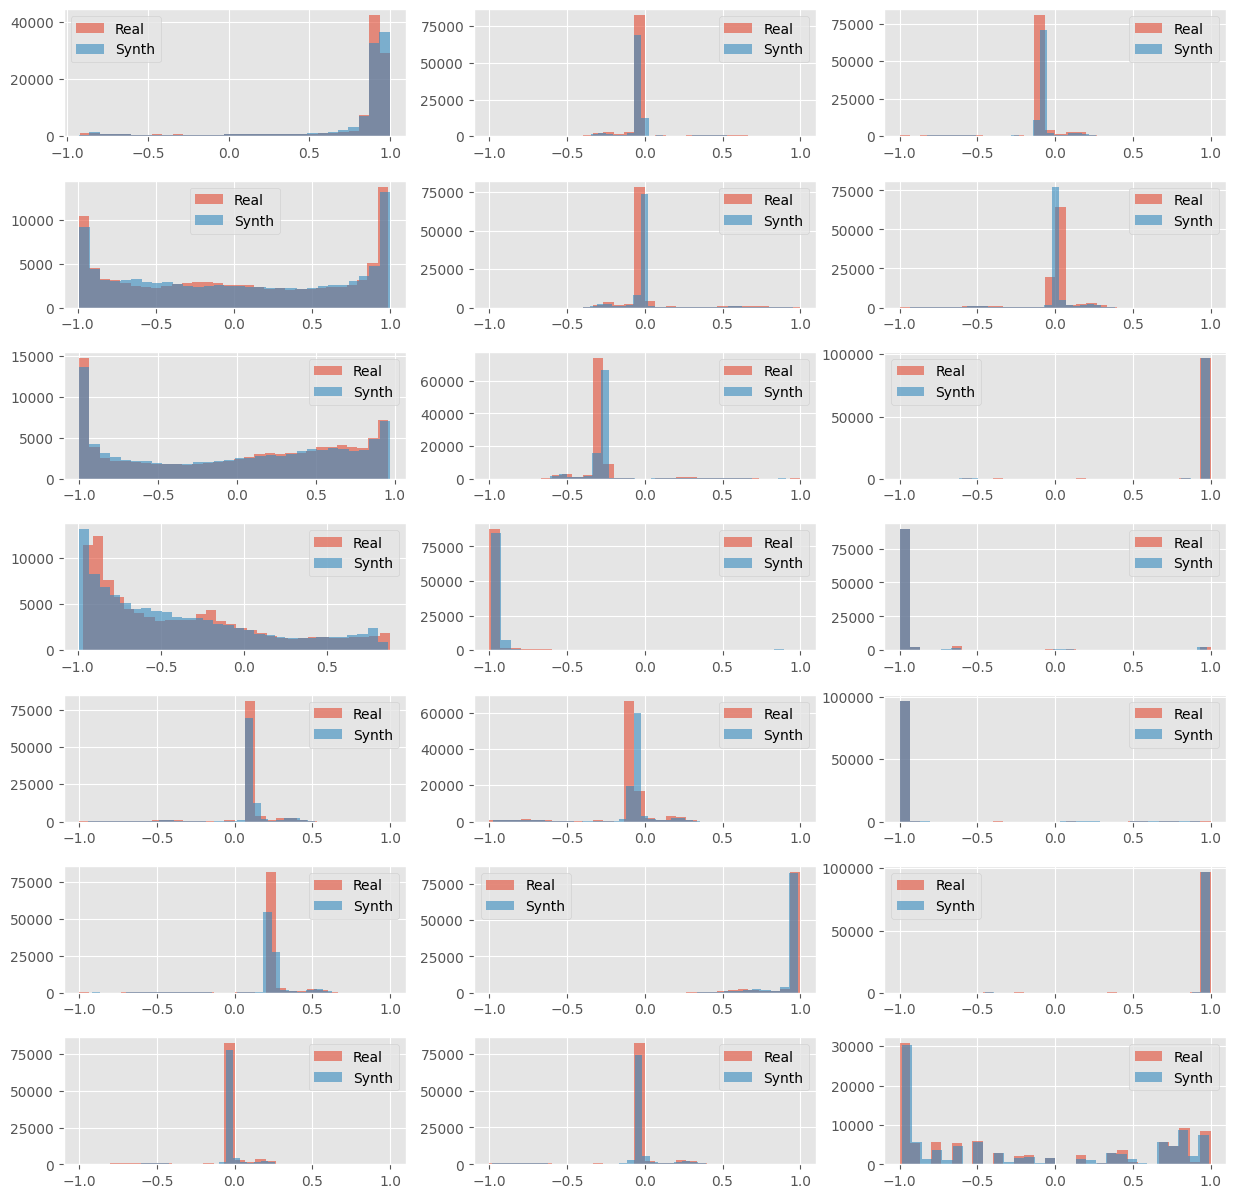

In [15]:
fig, axs = plt.subplots(7, 3, figsize=(15, 15), dpi=100)

for i in range(7):
    for j in range(3):
        axs[i, j].hist(X_gr[j, i], bins=30, label='Real', alpha=0.6)
        axs[i, j].hist(X_gr_s[j, i], bins=30, label='Synth', alpha=0.6)

        axs[i, j].legend()

plt.subplots_adjust(hspace=0.35)
# plt.savefig('results_synth_exp4.png', dpi=300)
plt.show()

### Compare mcc

<Axes: title={'center': 'Caregorical distribution'}, xlabel='MCC', ylabel='Density'>

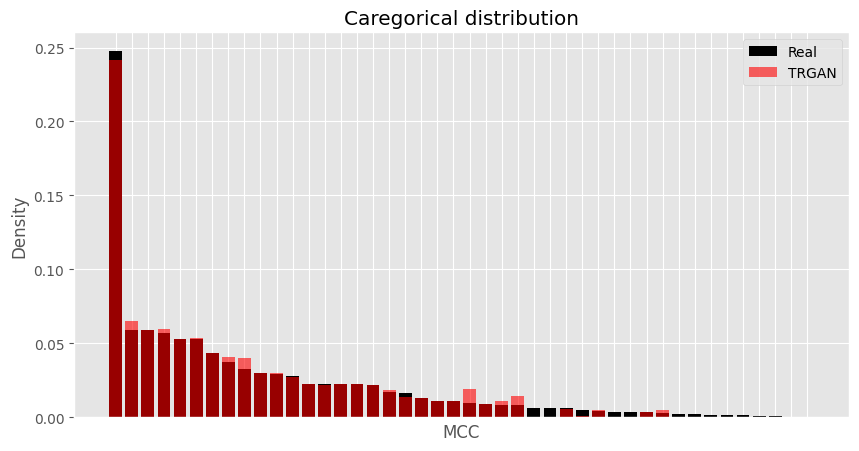

In [18]:

compare_categorical(
    data.mcc,
    rr.mcc
)

In [19]:
from TRGAN.evaluation_metrics import evaluate_categorical
rr["mcc"] = rr["mcc"].astype("int")
evaluate_categorical(
    data_array=[
        data['mcc'], 
        rr['mcc']
    ], 
    index=['Real', 'TRGAN'], 
    data_cont_array=[
        data[['mcc', 'transaction_date']], 
        rr[['mcc', 'transaction_date']]
    ])

[1.0, 0.18970999999999993]


,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.00000,1.00000,44.0,0.000000
TRGAN,0.95503,0.18971,32.0,0.071435


In [20]:
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.add_column(
    column_name='amount',
    sdtype='numerical',
    computer_representation='Float')

metadata.add_column(
    column_name='mcc',
    sdtype='categorical')


metadata.add_column(
    column_name='customer',
    sdtype='categorical')


metadata.add_column(
    column_name='transaction_date',
    sdtype='datetime',
    datetime_format='%Y %m %d')

In [21]:
from sdmetrics.single_table import NewRowSynthesis

NewRowSynthesis.compute(
    # real_data=data.drop('index', axis=1),
    real_data=data,
    synthetic_data=rr,
    metadata=metadata,
    numerical_match_tolerance=0.01,
    synthetic_sample_size=10_000
)

0.9769

### Compare clients' features

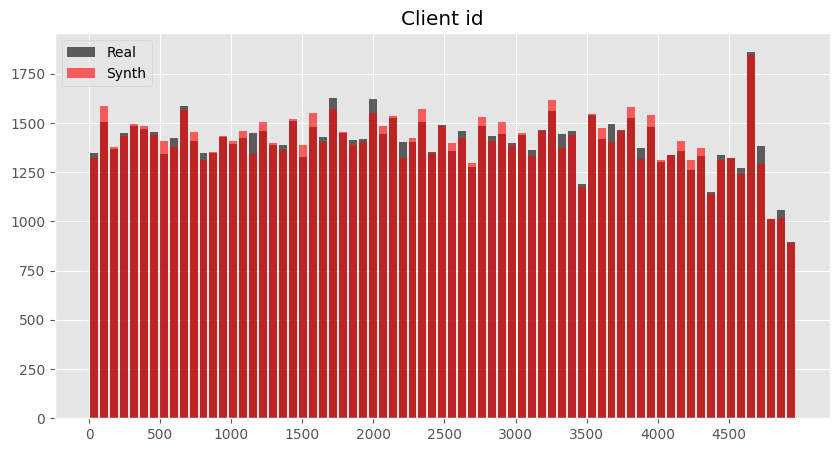

In [22]:
fig, axs = plt.subplots(figsize=(10, 5), dpi=100)

plt.hist(
    data["customer"],
    alpha=0.6,
    label="Real",
    bins=np.arange(0, 5000, 70),
    color="black",
    rwidth=0.8,
)
plt.hist(
    rr["customer"],
    alpha=0.6,
    label="Synth",
    bins=np.arange(0, 5000, 70),
    color="red",
    rwidth=0.8,
)

plt.legend()
plt.xticks(
    np.arange(0, len(data["customer"].value_counts()), 500),
    np.arange(0, len(data["customer"].value_counts()), 500),
)
plt.title("Client id")

plt.show()

array([<Axes: title={'center': 'PCA'}, xlabel='$X_1$', ylabel='$X_2$'>,
       <Axes: title={'center': 't-SNE'}, xlabel='$X_1$', ylabel='$X_2$'>],
      dtype=object)

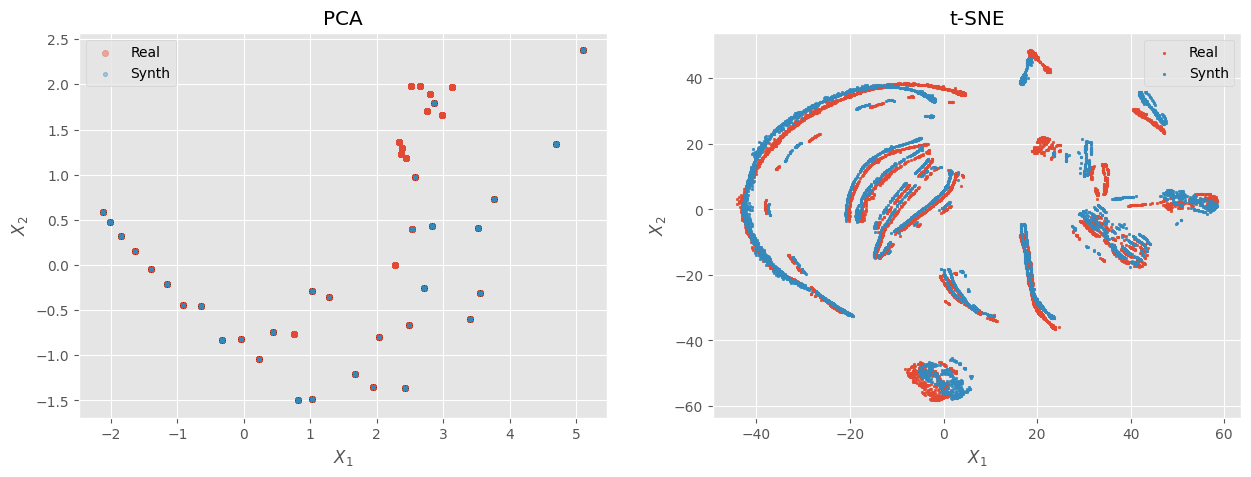

In [25]:
from TRGAN.comparison import plot_embeddings


plot_embeddings(model, data, rr)

## Comparison with other models

In [11]:
from TRGAN.methods_comparison import generate_samples
from TRGAN.methods_comparison import train_copulagan
from TRGAN.methods_comparison import train_ctgan
from TRGAN.methods_comparison import train_tvae

Prepare metadata for methods

In [12]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

metadata.add_column(
    column_name='amount',
    sdtype='numerical',
    computer_representation='Float')

metadata.add_column(
    column_name='mcc',
    sdtype='categorical')

metadata.add_column(
    column_name='transaction_date',
    sdtype='datetime',
    datetime_format='%Y %m %d')

Choose categorical columns for metrics calculation

In [13]:
data_no_customer = data[['mcc', 'amount', 'transaction_date']]

In [14]:
copulagan = train_copulagan(
    data_no_customer,
    metadata,
    "copulagan_model.pkl",
    epochs=3
)

ctgan = train_ctgan(
    data_no_customer,
    metadata,
    "ctgan_model.pkl",
    epochs=3
)


tvae = train_tvae(
    data_no_customer,
    metadata,
    "tvae_model.pkl",
    epochs=3
)



In [15]:
df_copulagan = generate_samples(copulagan, metadata, n_samples=100000)
df_ctgan = generate_samples(ctgan, metadata, n_samples=100000)
df_tvae = generate_samples(tvae, metadata, n_samples=100000)


### Compare categorical columns

<Axes: title={'center': 'Caregorical distribution'}, xlabel='MCC', ylabel='Density'>

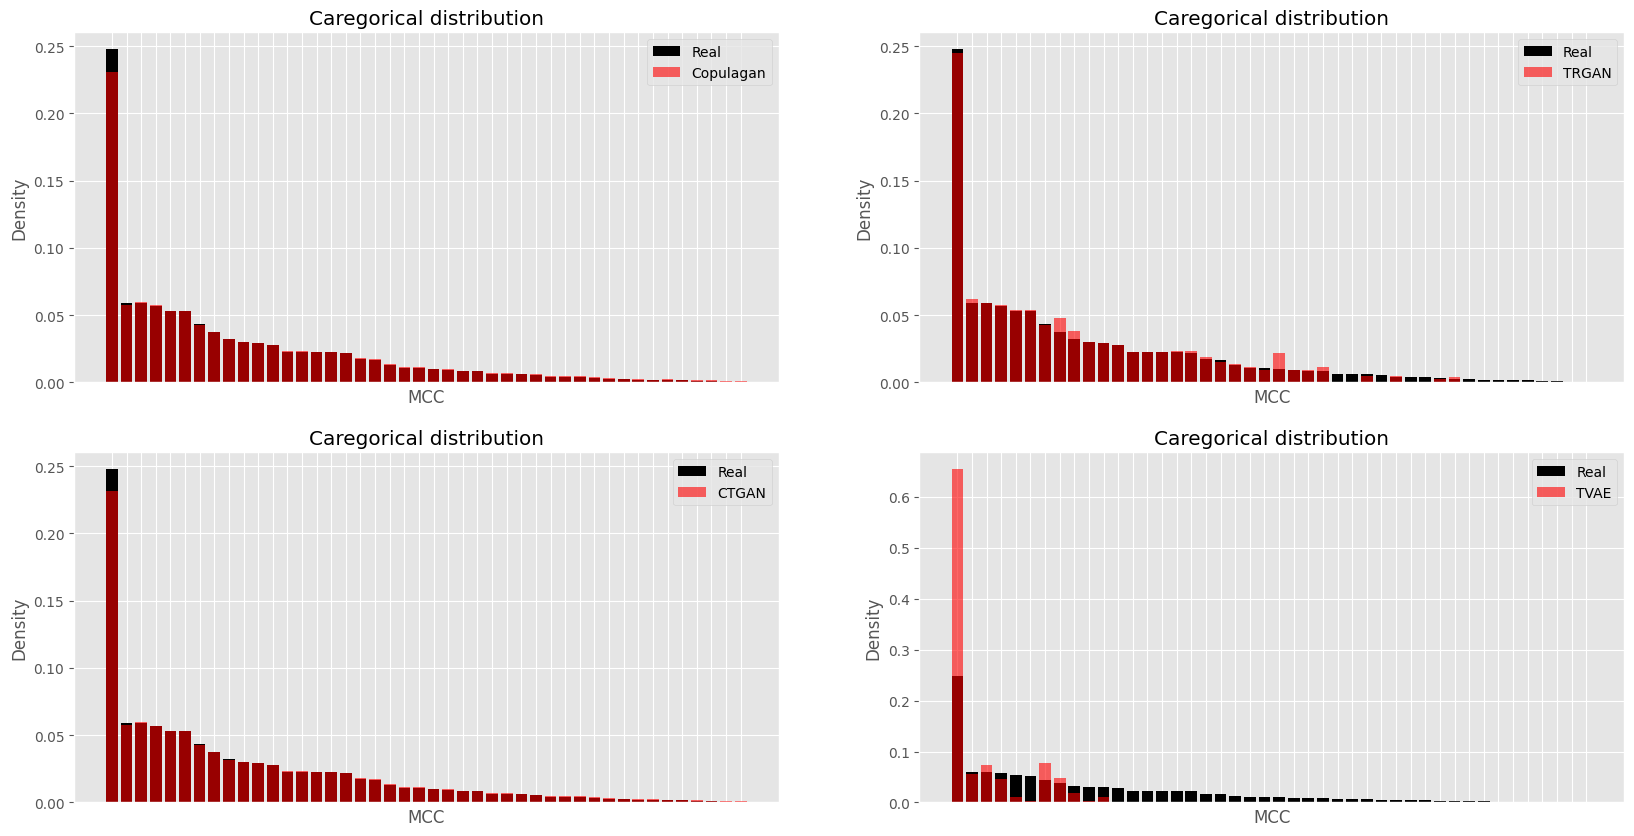

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)
compare_categorical(data.mcc, 
                    df_copulagan.mcc, 
                    ax=axs[0,0], 
                    label="Copulagan")
compare_categorical(data.mcc, 
                    rr.mcc, 
                    ax=axs[0,1], 
                    label="TRGAN")
compare_categorical(data.mcc, 
                    df_ctgan.mcc, 
                    ax=axs[1,0], 
                    label="CTGAN")
compare_categorical(data.mcc, 
                    df_tvae.mcc, 
                    ax=axs[1,1], 
                    label="TVAE")

In [ ]:
eval_cat = evaluate_categorical([data[comp_col], synth_df[comp_col], synth_ctgan[comp_col], synth_copulagan[comp_col], synth_banksformer[comp_col]],\
                                     index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'],\
data_cont_array=[data[contig_cols], synth_df[contig_cols], synth_ctgan[contig_cols], synth_copulagan[contig_cols], synth_banksformer[contig_cols]])


### Compare numerical columns

<Axes: title={'center': 'Numerical distribution of the amount'}, xlabel='Amount', ylabel='Density'>

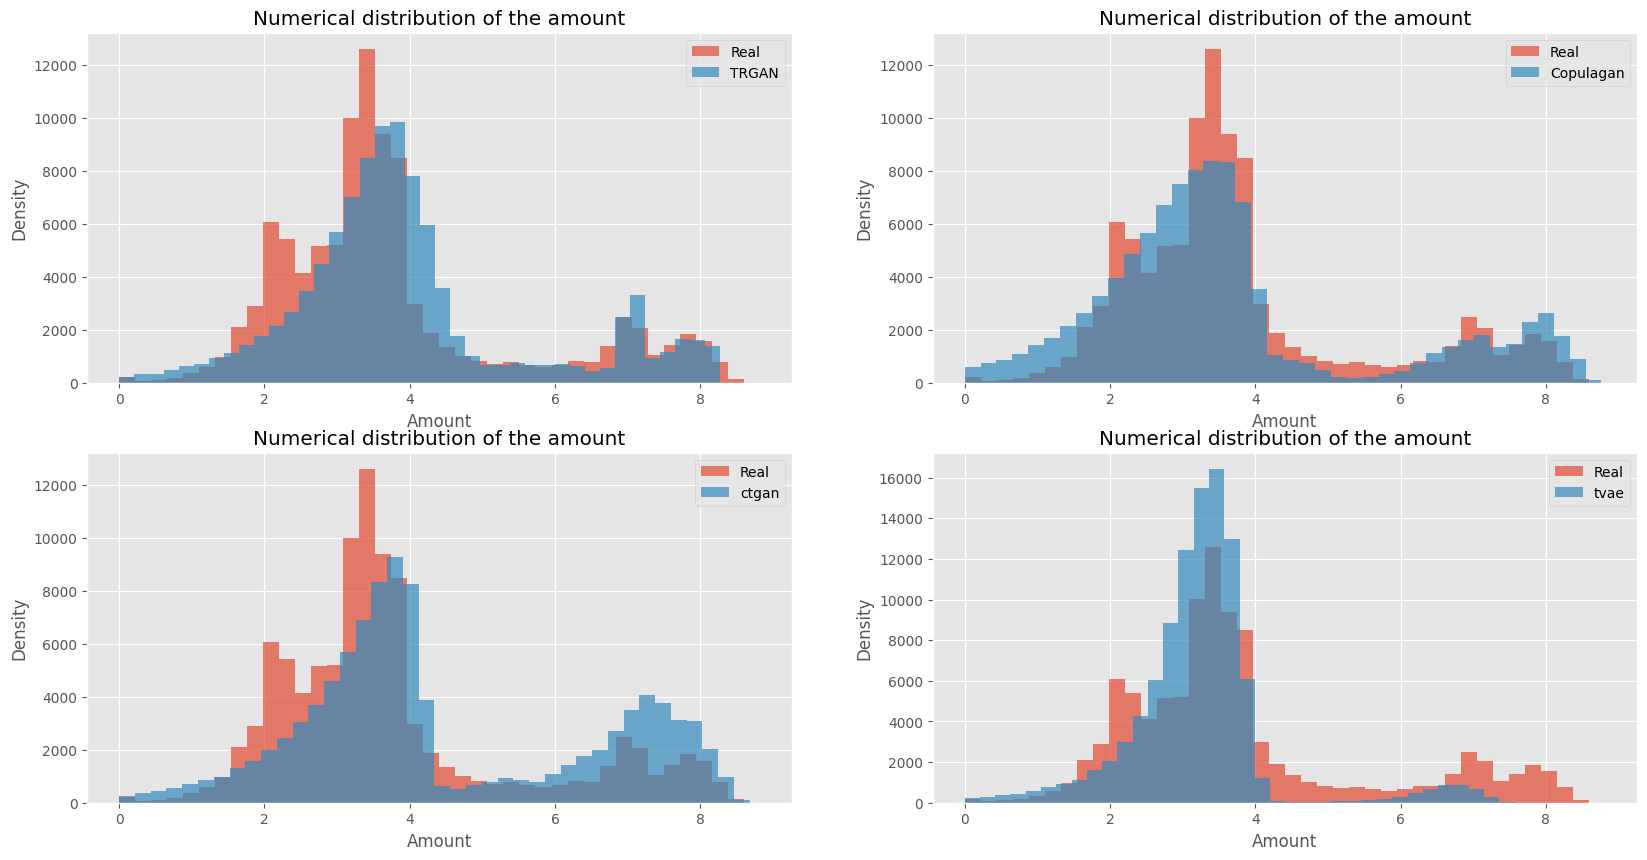

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)
compare_amount(data.amount, rr.amount, ax=axs[0,0], label="TRGAN")
compare_amount(data.amount, df_copulagan.amount, ax=axs[0,1], label="Copulagan")
compare_amount(data.amount, df_ctgan.amount, ax=axs[1,0], label="ctgan")
compare_amount(data.amount, df_tvae.amount, ax=axs[1,1], label="tvae")

In [26]:
from TRGAN.evaluation_metrics import evaluate_numerical

comp_col = "amount"
eval_num = evaluate_numerical(
    [
        np.log1p(np.abs(data[comp_col])), 
        np.log1p(np.abs(rr[comp_col])), 
        np.log1p(np.abs(df_ctgan[comp_col])),
        np.log1p(np.abs(df_copulagan[comp_col]))
        ],
        ['Real', 'TRGAN', 'CTGAN', 'CopulaGAN']
)
eval_num

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,3.802952,1.692282,0.558295,1.106460,0.000000,0.00000,0.000000
TRGAN,3.980722,1.657419,0.493708,0.852125,0.021766,0.13876,0.216221
CTGAN,4.469932,2.013430,-0.931795,0.410878,0.053699,0.19869,0.702526
CopulaGAN,3.677591,1.966544,0.192310,0.975279,0.042028,0.11194,0.281755


Text(0.5, 1.0, 'log(1 + Monthly Cash flow)')

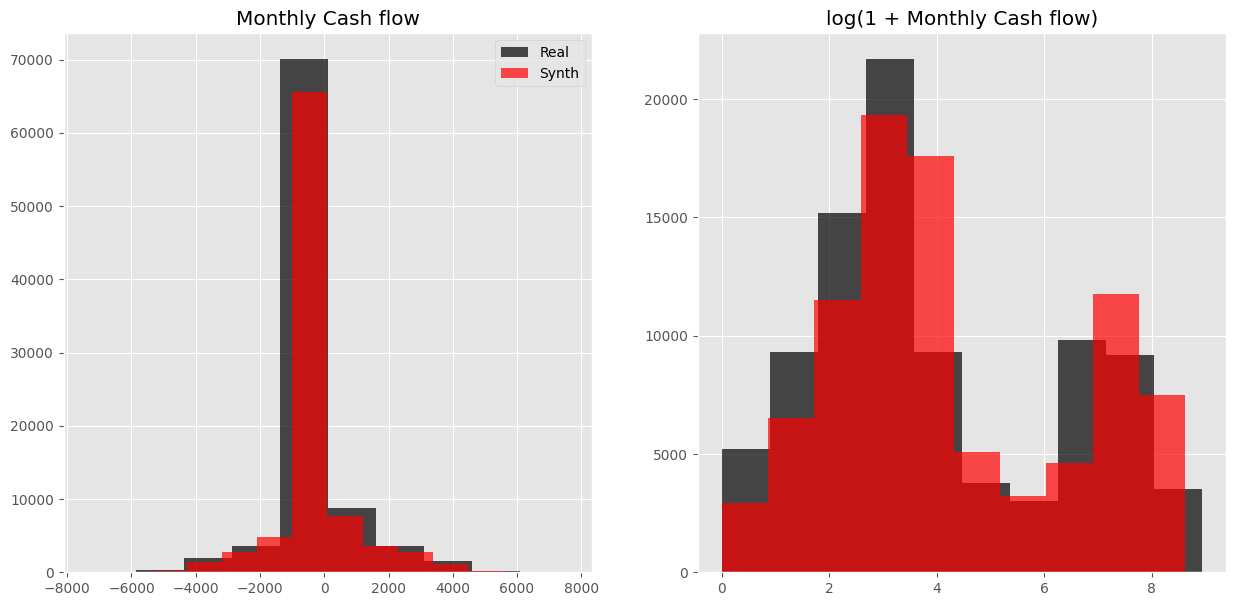

In [42]:
from TRGAN.comparison import get_cashflow


fig,ax = plt.subplots(1, 2, figsize=(15, 7), dpi=100)
cash_flow_real = get_cashflow(data)
cash_flow_synth = get_cashflow(rr, data.customer)

ax[0].hist(cash_flow_real, alpha=0.7, color="black", label="Real")
ax[0].hist(cash_flow_synth,  alpha=0.7, color="red", label="Synth")
ax[0].set_title("Monthly Cash flow")
ax[0].legend()

ax[1].hist(np.log1p(np.abs(cash_flow_real)),  color="black", alpha=0.7,label="Real")
ax[1].hist(np.log1p(np.abs(cash_flow_synth)), color="red", alpha=0.7,label="Synth")
ax[1].set_title("log(1 + Monthly Cash flow)")

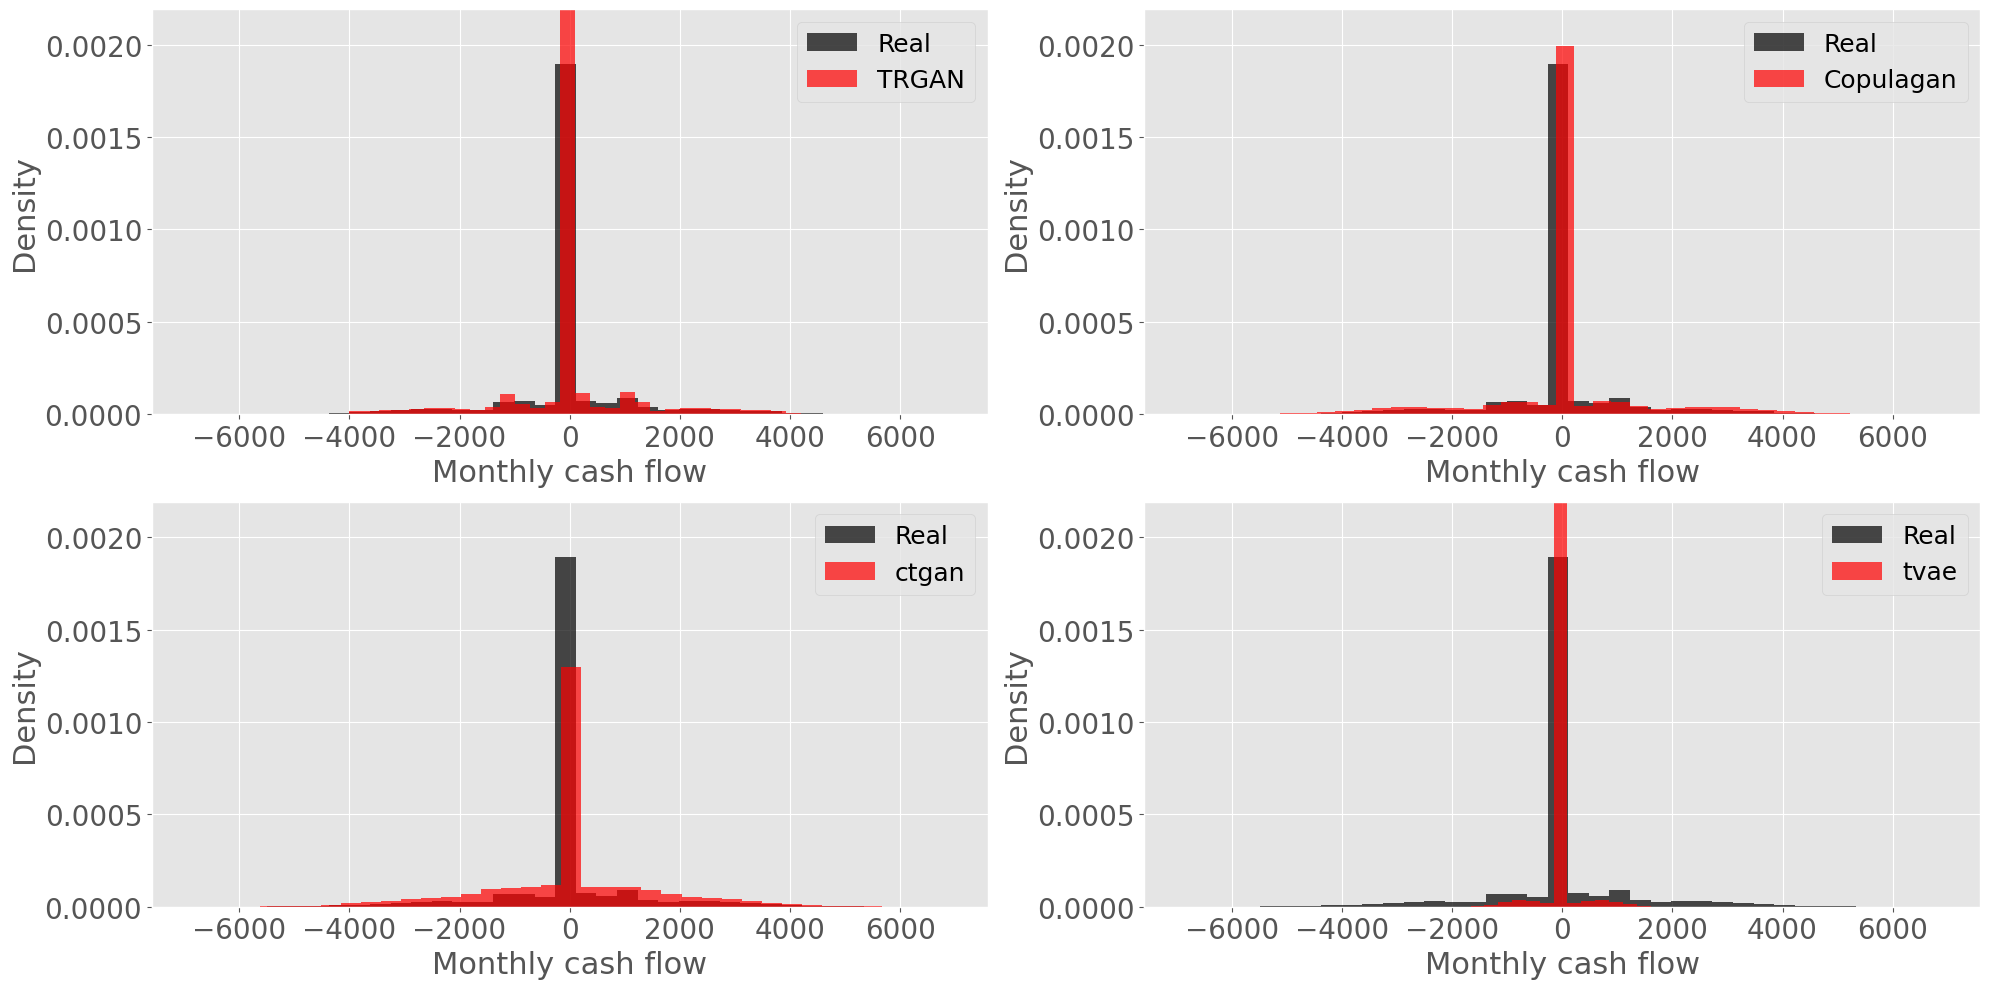

In [33]:
from TRGAN.comparison import compare_cashflow
fig, ax = plt.subplots(2, 2, figsize=(20, 10), dpi=100)
compare_cashflow(data, rr, ax=ax[0,0], label="TRGAN")
compare_cashflow(data, df_copulagan, ax=ax[0,1], label="Copulagan")
compare_cashflow(data, df_ctgan, ax=ax[1,0], label="ctgan")
compare_cashflow(data, df_tvae, ax=ax[1,1], label="tvae")
fig.tight_layout()

In [34]:
from TRGAN.evaluation_metrics import evaluate_numerical_cashflow


eval_cashflow = evaluate_numerical_cashflow(
        data,
        [rr, df_ctgan, df_copulagan, df_tvae],
        ['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'TVAE']
)
eval_cashflow

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,7.735231,1085.604543,6.289818,-0.000274,0.000000,0.000000,0.000000
TRGAN,15.371145,1098.175594,4.961507,0.031801,0.031449,0.051223,36.052759
CTGAN,1.221155,1469.978124,1.885076,-0.015517,0.232848,0.130402,405.204386
CopulaGAN,-0.778698,1358.461215,3.774789,0.002153,0.074863,0.051976,180.853640
TVAE,-0.048343,214.486396,36.939861,-0.241541,0.339680,0.155164,433.625858
